# Get Started of ∇-Prox Training

In [5]:
import torch
import torch.nn as nn
from dprox import *
from dprox.utils import *
from dprox.contrib.optic import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
x = Variable()
y = Placeholder()
PSF = Placeholder()
data_term = sum_squares(conv_doe(x, PSF, circular=True), y)
reg_term = deep_prior(x, denoiser='ffdnet_color')
solver = compile(data_term + reg_term, method='admm')

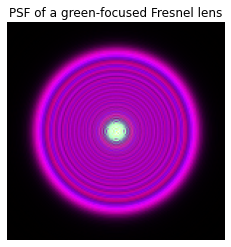

In [10]:
doe_model = build_doe_model().to(device)
psf = doe_model.get_psf()
psf_original = crop_center_region(normalize_psf(to_ndarray(psf, debatch=True), clip_percentile=0.01))
imshow(psf_original, titles=["PSF of a green-focused Fresnel lens"])

In [7]:
max_iter = 10
sigma = 7.65 / 255.
rhos, lams = log_descent(49, 7.65, max_iter, sigma=max(0.255 / 255, sigma))
doe_model.rhos = nn.parameter.Parameter(rhos)
doe_model.lams = nn.parameter.Parameter(lams)

solver = specialize(solver, method='unroll', max_iter=max_iter)

def step_fn(gt):
    gt = gt.to(device).float()
    psf = doe_model.get_psf()
    inp = img_psf_conv(gt, psf, circular=True)
    inp = inp + torch.randn(*inp.shape, device=inp.device) * sigma
    y.value = inp
    PSF.value = psf

    out = solver.solve(x0=inp, rhos=doe_model.rhos, lams={reg_term: doe_model.lams.sqrt()})
    return gt, inp, out


In [8]:
train(doe_model, step_fn, dataset='BSD500', epochs=1)

Epcoh[0]: 100%|██████████| 100/100 [01:06<00:00,  1.41it/s, loss=0.0021, psnr=27.7403]Epoch 0 Loss=0.002129327014554292 LR=0.0001
Epoch 0 Loss=0.002129327014554292 LR=0.0001
Epcoh[0]: 100%|██████████| 100/100 [01:06<00:00,  1.49it/s, loss=0.0021, psnr=27.7403]


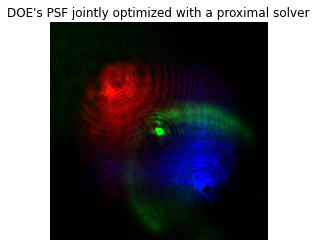

In [9]:
psf = doe_model.get_psf()
psf_dprox = crop_center_region(normalize_psf(to_ndarray(psf, debatch=True), clip_percentile=0.01))
imshow(psf_dprox, titles=["DOE's PSF jointly optimized with a proximal solver"])